In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.cuda import amp
from tqdm.notebook import tqdm
import random
import numpy as np
import math
import os

import warnings
warnings.filterwarnings('ignore')

In [15]:
config = {
    "beta_start": 1e-4,
    "beta_end": 0.02,
    "steps": 1000,
    "device_id": 0,
    "image_size": 32,
    "image_channel": 3,
    "epochs": 50,
    "lr": 3e-4,
    "weight_decay": 0,
    "batch_size": 200,
    "num_class": 10,
    "pos_dim": 1024,
    "patience": 10
}

# Class labels for CIFAR-10
class_labels = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

device = torch.device(f"cuda:{config['device_id']}" if torch.cuda.is_available() else "cpu")

In [16]:
# Forward pass
def forward_pass(images, t):
    batch_sqrt_alphas_cumprod = sqrt_alphas_cumprod[t]
    batch_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod[t]
    noise = torch.randn_like(images).cuda(config['device_id'])

    return batch_sqrt_alphas_cumprod * images + batch_sqrt_one_minus_alphas_cumprod * noise, noise

def sampling(model, labels, cfg_scale: int = 3, epoch: int = 0):
    # Extract relevant parameters from the config dictionary
    steps = config["steps"]
    image_size = config["image_size"]
    image_channel = config["image_channel"]
    device_id = config["device_id"]
    num_classes = config["num_class"]

    class_labels = [
        "Airplane", "Automobile", "Bird", "Cat", "Deer",
        "Dog", "Frog", "Horse", "Ship", "Truck"
    ]

    # Create output directory if it doesn't exist
    output_dir = "generated_images"
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        # Initialize random noise tensor
        x = torch.randn(labels.shape[0], image_channel, image_size, image_size).cuda(device_id)

        for i in tqdm(range(steps - 1, -1, -1)):
            # Time step tensor
            t = torch.tensor([i] * labels.shape[0]).cuda(device_id)

            # Classifier-free guidance
            predicted_noise_no_label = model(x, t, None)
            predicted_noise_with_label = model(x, t, labels)
            predicted_noise = torch.lerp(predicted_noise_no_label, predicted_noise_with_label, cfg_scale)

            # Conditional noise handling
            if i == 0:
                noise = torch.zeros_like(x).cuda(device_id)
            else:
                noise = torch.randn_like(x).cuda(device_id)

            # Update step for x
            x = one_over_sqrt_alpha[t] * (
                x - ((one_minus_alpha[t]) / (sqrt_one_minus_alphas_cumprod[t])) * predicted_noise
            ) + sqrt_beta[t] * noise

    model.train()

    # Post-process the generated images
    x = (x.clamp(-1, 1) + 1) / 2  # Scale to [0, 1]
    x = (x * 255).type(torch.uint8)  # Scale to [0, 255]

    # Plot all generated images in a row
    num_images = x.shape[0]
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

    for i, ax in enumerate(axes):
        # Convert tensor to (H, W, C) format for visualization
        tensor = x[i].permute(1, 2, 0).to("cpu").numpy()
        ax.imshow(tensor)
        ax.axis("off")
        ax.set_title(f"{class_labels[labels[i].item()]}", fontsize=10)

    # Add overall title
    plt.suptitle(f"Generated Images (Epoch: {epoch}, Number of Classes: {num_classes})", fontsize=14)
    plt.tight_layout()

    # Save the plot
    output_file = os.path.join(output_dir, f"generated_images_epoch_{epoch}.png")
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()
    print(f"Saved generated images to {output_file}")


def positional_embedding(num_step: int, emb_dim: int) -> torch.Tensor:
    """
    Create positional embedding tensor.

    :param num_step: Number of time steps.
    :param emb_dim: Embedding dimension.
    :return: Positional embedding tensor.
    """
    matrix = torch.zeros(num_step, emb_dim)
    for i in range(num_step):
        for j in range(0, emb_dim, 2):
            matrix[i, j] = np.sin(i/(10000**(j/emb_dim)))
            if(j+1<emb_dim):
                matrix[i, j+1] = np.cos(i/(10000**(j/emb_dim)))

    return matrix

def sinusoidal_positional_encoding_2d(height: int, width: int, channel: int) -> torch.Tensor:
    """
    Generate a 2D sinusoidal positional encoding.

    :param height: The height of the encoding.
    :param width: The width of the encoding.
    :param channel: The number of channels in the encoding.
    :return: A tensor of shape (height, width, channel) containing the 2D positional encoding.
    """
    if channel % 2 != 0:
        raise ValueError("The 'channel' dimension must be an even number.")

    # First, build in (height, width, channel) format
    pe = torch.zeros(height, width, channel)

    half_ch = channel // 2

    # Precompute the exponent for row and column
    row_div_term = torch.exp(
        -math.log(10000.0) * (torch.arange(0, half_ch, 2).float() / half_ch)
    )
    col_div_term = torch.exp(
        -math.log(10000.0) * (torch.arange(0, half_ch, 2).float() / half_ch)
    )

    for h in range(height):
        for w in range(width):
            # Encode row index (h) into the first half of the channels
            for i in range(0, half_ch, 2):
                pe[h, w, i]     = math.sin(h * row_div_term[i // 2])
                pe[h, w, i + 1] = math.cos(h * row_div_term[i // 2])

            # Encode column index (w) into the second half of the channels
            for j in range(0, half_ch, 2):
                pe[h, w, half_ch + j]     = math.sin(w * col_div_term[j // 2])
                pe[h, w, half_ch + j + 1] = math.cos(w * col_div_term[j // 2])

    # Permute to get the shape (channel, width, height).
    # Currently pe is (height, width, channel) = (H, W, C)
    # We want (C, W, H), so we do permute(2, 1, 0).
    pe = pe.permute(2, 1, 0)  # => (channel, width, height)

    return pe

def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

In [17]:
class AdaNorm(nn.Module):
    def __init__(self, num_channel: int, channel_per_group: int = 16, emb_dim: int = 1024):
        super().__init__()
        assert num_channel % channel_per_group == 0, "num_channel must be divisible by channel_per_group"
        num_group = num_channel // channel_per_group
        self.embedding_proj = nn.Sequential(
            nn.Linear(emb_dim, 2 * num_channel),
            nn.ReLU()
        )
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, embedding: torch.Tensor) -> torch.Tensor:
        """
        Perform adanormalization on input tensor.

        :param tensor: Input tensor to be normalized.
        :param embedding: Embedding tensor containing time embedding and potentially class embedding.
        :return: Normalized tensor.
        """
        embedding = self.embedding_proj(embedding)
        embedding = embedding.view(embedding.shape[0], embedding.shape[1], 1, 1)
        scale, shift = torch.chunk(embedding, 2, dim=1)

        tensor = self.gnorm(tensor)
        # tensor = tensor * torch.sigmoid(scale) + shift
        tensor = tensor * (1 + scale) + shift
        return tensor

class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False, channel_per_group: int = 16):
        super().__init__()

        # Upsampling or downsampling only for skip connection
        self.up = up
        self.down = down

        # Normalization layers
        self.norm1 = AdaNorm(in_channel, emb_dim=emb_dim)
        self.norm2 = AdaNorm(out_channel, emb_dim=emb_dim)

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        self.conv2 = zero_out(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1))

        # Skip connection
        if in_channel != out_channel or up or down:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1),
                nn.Upsample(scale_factor=2) if up else nn.Identity(),
                nn.AvgPool2d(kernel_size=2) if down else nn.Identity(),
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, tensor: torch.Tensor, embedding: torch.Tensor) -> torch.Tensor:
        skip_tensor = self.skip_connection(tensor)

        # Main path
        tensor = self.norm1(tensor, embedding)
        tensor = F.relu(tensor)
        if self.up:
            tensor = F.interpolate(tensor, scale_factor=2)
        if self.down:
            tensor = F.avg_pool2d(tensor, kernel_size=2)
        tensor = self.conv1(tensor)
        tensor = self.norm2(tensor, embedding)
        tensor = F.relu(tensor)
        tensor = self.conv2(tensor)

        tensor += skip_tensor
        return tensor


class SelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int, image_size: int, head_dim: int = 64, channel_per_group: int = 16):
        super().__init__()
        self.head_dim: int = head_dim
        self.num_head: int = embedding_dim // head_dim
        self.scale: float = head_dim ** -0.5
        self.num_pixel = image_size ** 2
        self.gnorm1 = nn.GroupNorm(embedding_dim // channel_per_group, embedding_dim)
        self.gnorm2 = nn.GroupNorm(embedding_dim // channel_per_group, embedding_dim)

        # QKV projection
        self.qkv_proj = nn.Linear(embedding_dim, embedding_dim * 3)

        # Output layer
        self.output = zero_out(nn.Conv2d(embedding_dim, embedding_dim, kernel_size=1))

        # Positional embedding for patches
        self.positional_encoding = nn.Parameter(sinusoidal_positional_encoding_2d(image_size, image_size, embedding_dim))
        self.positional_encoding.requires_grad_(False)

        # Feed Forward Layer
        self.ffn1 = nn.Conv2d(embedding_dim, embedding_dim * 8, kernel_size=1)
        self.ffn2 = nn.Conv2d(embedding_dim * 8, embedding_dim, kernel_size=1)

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        skip_tensor = tensor

        tensor = self.gnorm1(tensor)

        # Reshape for self attention
        batch_size, channel, height, width = tensor.shape
        tensor = tensor + self.positional_encoding
        tensor = tensor.view(batch_size, channel, self.num_pixel)
        tensor = tensor.permute(0, 2, 1)

        tensor = self.qkv_proj(tensor)

        query, key, value = torch.chunk(tensor, 3, dim=-1)
        query = query.view(batch_size, self.num_pixel, self.num_head, self.head_dim)
        key = key.view(batch_size, self.num_pixel, self.num_head, self.head_dim)
        value = value.view(batch_size, self.num_pixel, self.num_head, self.head_dim)

        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Self attention
        attention_raw = torch.matmul(query, key.transpose(2, 3))
        attention_scaled = attention_raw * self.scale
        attention_score = torch.softmax(attention_scaled, dim=-1)
        value = torch.matmul(attention_score, value)

        # Reshape for self attention output
        tensor = value.transpose(1, 2).contiguous()
        tensor = tensor.view(batch_size, self.num_pixel, channel)
        tensor = tensor.permute(0, 2, 1)
        tensor = tensor.reshape(batch_size, channel, height, width)
        tensor = self.output(tensor)

        tensor = tensor + skip_tensor

        # Feed Forward Layer
        tensor = self.gnorm2(tensor)
        tensor = self.ffn1(tensor)
        tensor = F.relu(tensor)
        tensor = self.ffn2(tensor)

        return tensor

class UNet(nn.Module):
    def __init__(self, image_channel: int = 3, image_size: int = 32, channels: list[int] = [64, 128, 256, 512], attention_channels = [128, 256, 512], depth: int = 2, emb_dim: int = 1024, num_step: int = 1000, num_classes: int = 10, channel_per_group: int = 16, patch_size: int = 2, head_dim: int = 32):
        super().__init__()
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()
        skip_channel = [channels[0]]
        image_size = [image_size // (2**i) for i in range(len(channels))]

        self.positional_encoding = nn.Embedding(num_step, emb_dim)
        self.positional_encoding.weight.data.copy_(positional_embedding(num_step, emb_dim))
        self.positional_encoding.weight.requires_grad = False

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim, channel_per_group=channel_per_group))
                if channels[i] in attention_channels:
                    layer.append(SelfAttentionBlock(channels[i], image_size[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            # Down projection
            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim, channel_per_group=channel_per_group))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1], channel_per_group=channel_per_group),
            SelfAttentionBlock(channels[-1], image_size[-1]),
            ResBlock(channels[-1], channels[-1], channel_per_group=channel_per_group),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channels:
                    layer.append(SelfAttentionBlock(channels[i], image_size[i]))
                self.decoder.append(layer)

            # Up projection
            if i != 0:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i - 1], up=True, emb_dim = emb_dim))
                self.decoder.append(layer)
            else:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[0], emb_dim = emb_dim))
                self.decoder.append(layer)

        self.time_embedding_proj = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )
        self.class_embedding = nn.Embedding(num_classes, emb_dim)

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            nn.GroupNorm(channels[0] // channel_per_group, channels[0], affine=False),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, kernel_size = 1)),
        )

    def forward(self, tensor: torch.Tensor, time_step: torch.Tensor, label: torch.Tensor = None) -> torch.Tensor:
        """
        Diffusion model.

        :param tensor: Input tensor.
        :param time_step: Time step tensor.
        :param label: Label tensor.
        :return: Predicted noise.
        """
        embedding = self.positional_encoding(time_step)
        embedding = self.time_embedding_proj(embedding)

        if label != None:
            class_embedding = self.class_embedding(label)
            embedding = embedding + class_embedding

        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            tensor = torch.concatenate((tensor, skip_connection.pop()), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor

In [18]:
# Constants used for the diffusion model
beta = torch.linspace(config["beta_start"], config["beta_end"], config["steps"]).to(device)
sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
alpha = 1 - beta
alphas_cumprod = torch.cumprod(alpha, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)
one_minus_alphas_cumprod = 1 - alphas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod).view(-1, 1, 1, 1)
one_over_sqrt_alpha = 1 / torch.sqrt(alpha).view(-1, 1, 1, 1)
one_minus_alpha = (1 - alpha).view(-1, 1, 1, 1)

# Define the transformation
transform = transforms.Compose([
    # transforms.Resize(125),
    # transforms.RandomResizedCrop(config["image_size"], scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [19]:
# Load the training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the combined dataset
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(testset, batch_size=config["batch_size"], shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Instantiate the model
unet = UNet(num_classes=config["num_class"]).to(device)
print("This model has", sum(p.numel() for p in unet.parameters()), "parameters.")

This model has 118110787 parameters.


In [21]:
scaler = amp.GradScaler()
loss_train = []
loss_valid = []

# Set up optimizer and loss
optimizer = opt.AdamW(unet.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"] * len(train_dataloader), eta_min=1e-5)

In [22]:
def train_one_epoch(unet, train_dataloader, optimizer, scaler, criterion, scheduler, config, device):
    """Train the model for one epoch."""
    train_loss_list = []
    progress_bar = tqdm(train_dataloader, desc="Training", leave=False)

    for images, labels in progress_bar:
        # Zero out gradients
        optimizer.zero_grad()

        # Preparing for forward pass
        images = images.to(device)
        labels = labels.to(device)
        time_step = torch.randint(1, config["steps"], size=(images.shape[0],)).to(device)
        x_t, noise = forward_pass(images, time_step)

        # Classifier free guidance
        if random.random() < 0.1:
            labels = None

        # Forward pass
        with torch.cuda.amp.autocast():
            predicted_noise = unet(x_t, time_step, labels)
            loss = criterion(predicted_noise, noise)

        # Back propagation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Record loss
        train_loss_list.append(loss.item())

        # Update the learning rate scheduler
        scheduler.step()

        # Update tqdm description
        progress_bar.set_postfix({
            "Train Loss": f"{sum(train_loss_list) / len(train_loss_list):.4f}",
            "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
        })

    epoch_loss = sum(train_loss_list) / len(train_loss_list)
    print(f"End of epoch training loss: {epoch_loss:.4f}")
    return epoch_loss

def validate_one_epoch(unet, valid_dataloader, criterion, config, device):
    """Validate the model for one epoch and return validation loss and generated class samples."""
    valid_loss_list = []
    generated_samples = {label: None for label in range(config["num_class"])}

    with torch.no_grad():
        for images, labels in tqdm(valid_dataloader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            time_step = torch.randint(1, config["steps"], size=(images.shape[0],)).to(device)
            x_t, noise = forward_pass(images, time_step)

            with torch.cuda.amp.autocast():
                predicted_noise = unet(x_t, time_step, labels)
                loss = criterion(predicted_noise, noise)

            valid_loss_list.append(loss.item())

            # Generate one image per class for visualization
            for img, lbl in zip(x_t, labels):
                lbl = lbl.item()
                if generated_samples[lbl] is None:
                    generated_samples[lbl] = img.cpu()
                    if all(sample is not None for sample in generated_samples.values()):
                        break

    epoch_loss = sum(valid_loss_list) / len(valid_loss_list)
    print(f"End of epoch validation loss: {epoch_loss:.4f}")
    return epoch_loss, generated_samples

def plot_class_samples(class_samples, class_labels):
    """Plot one generated sample from each class."""
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        sample = class_samples[i]
        if sample is not None:
            sample = (sample.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1).numpy()
            ax.imshow(sample)
        ax.axis("off")
        ax.set_title(class_labels[i])
    plt.show()

def plot_loss_curve(loss_train, loss_valid):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(loss_train, label="Train Loss")
    plt.plot(loss_valid, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

def train_and_validate(unet, train_dataloader, valid_dataloader, optimizer, scaler, criterion, scheduler, config, device, load_last_checkpoint=False):
    """Train and validate the model across multiple epochs."""
    class_labels = [
        "Airplane", "Automobile", "Bird", "Cat", "Deer",
        "Dog", "Frog", "Horse", "Ship", "Truck"
    ]
    loss_train = []
    loss_valid = []

    best_valid_loss = float("inf")
    patience = config.get("patience", 10)
    patience_counter = 0

    # Load checkpoint if specified
    start_epoch = 1
    if load_last_checkpoint:
        checkpoint_path = config.get("checkpoint_path", "checkpoint.pth")
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            unet.load_state_dict(checkpoint["model_state"])
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            scaler.load_state_dict(checkpoint["scaler_state"])
            scheduler.load_state_dict(checkpoint["scheduler_state"])
            loss_train = checkpoint.get("loss_train", [])
            loss_valid = checkpoint.get("loss_valid", [])
            best_valid_loss = checkpoint.get("best_valid_loss", float("inf"))
            start_epoch = len(loss_train) + 1
            print(f"Checkpoint loaded from {checkpoint_path}. Resuming from epoch {start_epoch}.")
        except FileNotFoundError:
            print(f"Checkpoint not found at {checkpoint_path}, starting from scratch.")

    for epoch in range(start_epoch, config["epochs"] + 1):
        print(f"Epoch {epoch}/{config['epochs']}")
    
        # Train
        train_loss = train_one_epoch(unet, train_dataloader, optimizer, scaler, criterion, scheduler, config, device)
        loss_train.append(train_loss)
    
        # Initialize valid_loss
        valid_loss = None
    
        if epoch == 1 or epoch % 5 == 0 or epoch == config["epochs"]:
            # Validate
            valid_loss, generated_samples = validate_one_epoch(unet, valid_dataloader, criterion, config, device)
            loss_valid.append(valid_loss)
    
            # Plot generated class samples
            label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).cuda(config['device_id'])
            sampling(unet, label, epoch=epoch)
    
            # Save model if validation loss improves
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(unet.state_dict(), "best_unet_model.pth")
                print(f"Best model saved at epoch {epoch} with validation loss {valid_loss:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1
    
            # Early stopping
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
        # Save checkpoint
        checkpoint = {
            "model_state": unet.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "loss_train": loss_train,
            "loss_valid": loss_valid,
            "best_valid_loss": best_valid_loss
        }
        checkpoint_path = config.get("checkpoint_path", "checkpoint.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}.")
    
        # Log epoch losses and learning rate
        print(f"Epoch {epoch} Summary: Train Loss = {train_loss:.4f}, Validation Loss = {valid_loss if valid_loss is not None else 'N/A'}, LR = {optimizer.param_groups[0]['lr']:.6f}")
    
    # Plot loss curves after training
    plot_loss_curve(loss_train, loss_valid)


Epoch 1/1


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0344


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0279


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_1.png
Best model saved at epoch 1 with validation loss 0.0279
Checkpoint saved at checkpoint.pth.
Epoch 1 Summary: Train Loss = 0.0344, Validation Loss = 0.02788466326892376, LR = 0.000280


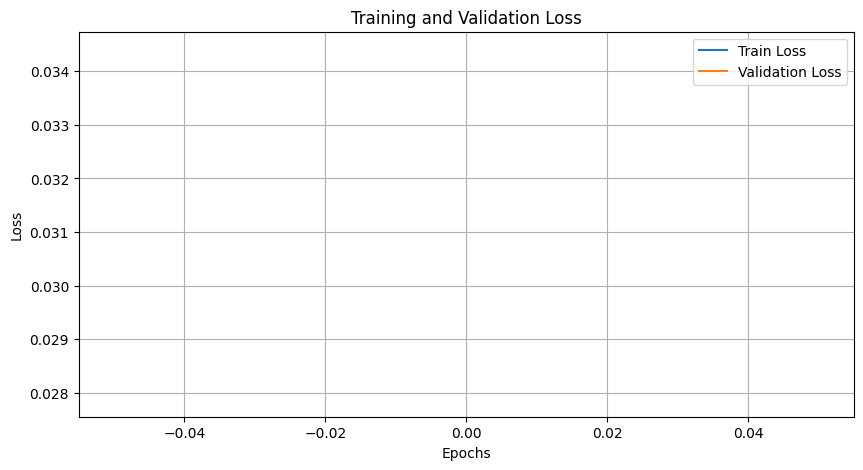

In [11]:
config['epochs'] = 1
train_and_validate(unet, train_dataloader, valid_dataloader, optimizer, scaler, criterion, scheduler, config, device, load_last_checkpoint=False)

Checkpoint loaded from checkpoint.pth. Resuming from epoch 21.
Epoch 21/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0194
Checkpoint saved at checkpoint.pth.
Epoch 21 Summary: Train Loss = 0.0194, Validation Loss = N/A, LR = 0.000293
Epoch 22/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0192
Checkpoint saved at checkpoint.pth.
Epoch 22 Summary: Train Loss = 0.0192, Validation Loss = N/A, LR = 0.000272
Epoch 23/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0192
Checkpoint saved at checkpoint.pth.
Epoch 23 Summary: Train Loss = 0.0192, Validation Loss = N/A, LR = 0.000240
Epoch 24/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0189
Checkpoint saved at checkpoint.pth.
Epoch 24 Summary: Train Loss = 0.0189, Validation Loss = N/A, LR = 0.000200
Epoch 25/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0185


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0188


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_25.png
Best model saved at epoch 25 with validation loss 0.0188
Checkpoint saved at checkpoint.pth.
Epoch 25 Summary: Train Loss = 0.0185, Validation Loss = 0.01876953735947609, LR = 0.000155
Epoch 26/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0186
Checkpoint saved at checkpoint.pth.
Epoch 26 Summary: Train Loss = 0.0186, Validation Loss = N/A, LR = 0.000110
Epoch 27/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0186
Checkpoint saved at checkpoint.pth.
Epoch 27 Summary: Train Loss = 0.0186, Validation Loss = N/A, LR = 0.000070
Epoch 28/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0186
Checkpoint saved at checkpoint.pth.
Epoch 28 Summary: Train Loss = 0.0186, Validation Loss = N/A, LR = 0.000038
Epoch 29/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0187
Checkpoint saved at checkpoint.pth.
Epoch 29 Summary: Train Loss = 0.0187, Validation Loss = N/A, LR = 0.000017
Epoch 30/30


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0184


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0191


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_30.png
Checkpoint saved at checkpoint.pth.
Epoch 30 Summary: Train Loss = 0.0184, Validation Loss = 0.019119268395006658, LR = 0.000010


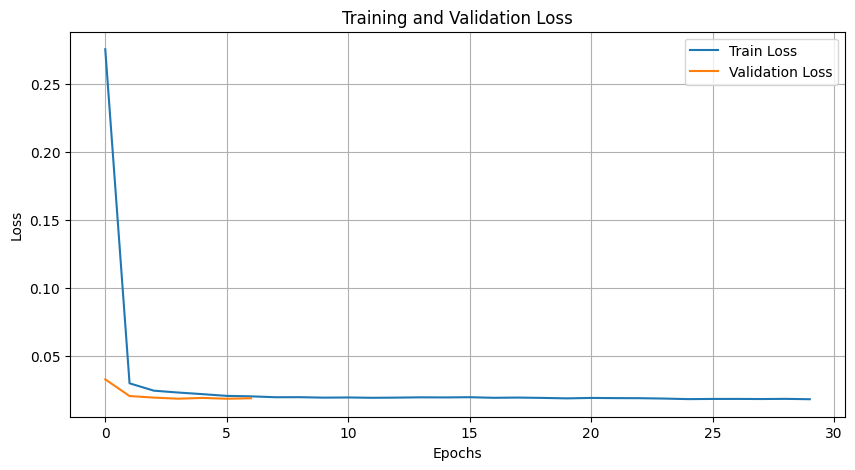

In [11]:
config['epochs'] = 30
train_and_validate(unet, train_dataloader, valid_dataloader, optimizer, scaler, criterion, scheduler, config, device, load_last_checkpoint=True)

Checkpoint loaded from checkpoint.pth. Resuming from epoch 31.
Epoch 31/35


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0183
Checkpoint saved at checkpoint.pth.
Epoch 31 Summary: Train Loss = 0.0183, Validation Loss = N/A, LR = 0.000010
Epoch 32/35


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0185
Checkpoint saved at checkpoint.pth.
Epoch 32 Summary: Train Loss = 0.0185, Validation Loss = N/A, LR = 0.000010
Epoch 33/35


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182
Checkpoint saved at checkpoint.pth.
Epoch 33 Summary: Train Loss = 0.0182, Validation Loss = N/A, LR = 0.000010
Epoch 34/35


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0181
Checkpoint saved at checkpoint.pth.
Epoch 34 Summary: Train Loss = 0.0181, Validation Loss = N/A, LR = 0.000010
Epoch 35/35


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0179


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0180


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_35.png
Best model saved at epoch 35 with validation loss 0.0180
Checkpoint saved at checkpoint.pth.
Epoch 35 Summary: Train Loss = 0.0179, Validation Loss = 0.018020733948796986, LR = 0.000010


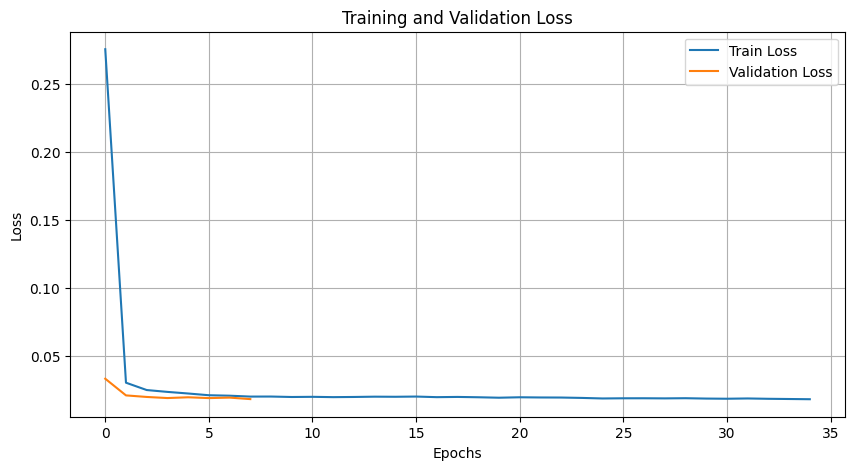

In [15]:
config['epochs'] = 35
train_and_validate(unet, train_dataloader, valid_dataloader, optimizer, scaler, criterion, scheduler, config, device, load_last_checkpoint=True)

Checkpoint loaded from checkpoint.pth. Resuming from epoch 36.
Epoch 36/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0186
Checkpoint saved at checkpoint.pth.
Epoch 36 Summary: Train Loss = 0.0186, Validation Loss = N/A, LR = 0.000010
Epoch 37/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0177
Checkpoint saved at checkpoint.pth.
Epoch 37 Summary: Train Loss = 0.0177, Validation Loss = N/A, LR = 0.000010
Epoch 38/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0186
Checkpoint saved at checkpoint.pth.
Epoch 38 Summary: Train Loss = 0.0186, Validation Loss = N/A, LR = 0.000010
Epoch 39/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0181
Checkpoint saved at checkpoint.pth.
Epoch 39 Summary: Train Loss = 0.0181, Validation Loss = N/A, LR = 0.000010
Epoch 40/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0188


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_40.png
Checkpoint saved at checkpoint.pth.
Epoch 40 Summary: Train Loss = 0.0182, Validation Loss = 0.018783782981336115, LR = 0.000010
Epoch 41/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0181
Checkpoint saved at checkpoint.pth.
Epoch 41 Summary: Train Loss = 0.0181, Validation Loss = N/A, LR = 0.000010
Epoch 42/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0184
Checkpoint saved at checkpoint.pth.
Epoch 42 Summary: Train Loss = 0.0184, Validation Loss = N/A, LR = 0.000010
Epoch 43/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0187


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0180


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_45.png
Best model saved at epoch 45 with validation loss 0.0180
Checkpoint saved at checkpoint.pth.
Epoch 45 Summary: Train Loss = 0.0187, Validation Loss = 0.018008443620055915, LR = 0.000010
Epoch 46/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182
Checkpoint saved at checkpoint.pth.
Epoch 46 Summary: Train Loss = 0.0182, Validation Loss = N/A, LR = 0.000010
Epoch 47/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182
Checkpoint saved at checkpoint.pth.
Epoch 47 Summary: Train Loss = 0.0182, Validation Loss = N/A, LR = 0.000010
Epoch 48/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0181
Checkpoint saved at checkpoint.pth.
Epoch 48 Summary: Train Loss = 0.0181, Validation Loss = N/A, LR = 0.000010
Epoch 49/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182
Checkpoint saved at checkpoint.pth.
Epoch 49 Summary: Train Loss = 0.0182, Validation Loss = N/A, LR = 0.000010
Epoch 50/50


Training:   0%|          | 0/250 [00:00<?, ?it/s]

End of epoch training loss: 0.0182


Validation:   0%|          | 0/50 [00:00<?, ?it/s]

End of epoch validation loss: 0.0181


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved generated images to generated_images/generated_images_epoch_50.png
Checkpoint saved at checkpoint.pth.
Epoch 50 Summary: Train Loss = 0.0182, Validation Loss = 0.01810223326086998, LR = 0.000010


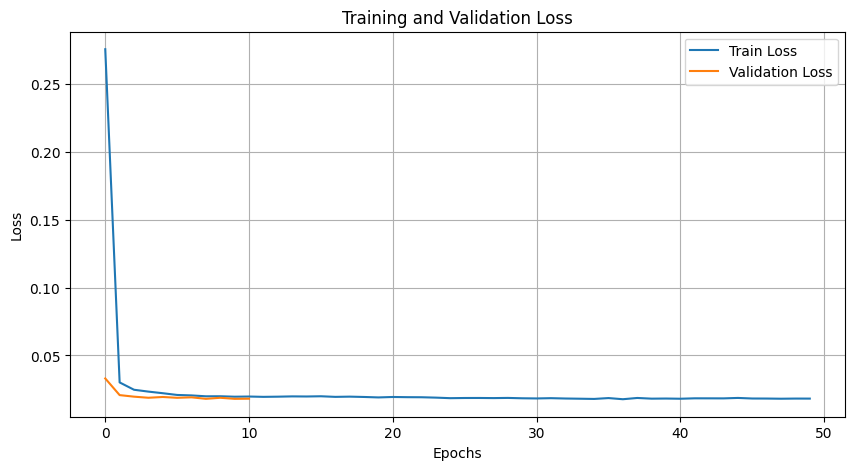

In [24]:
config['epochs'] = 50
train_and_validate(unet, train_dataloader, valid_dataloader, optimizer, scaler, criterion, scheduler, config, device, load_last_checkpoint=True)

In [40]:
def forward_diffusion(image, config, device):
    """
    Perform forward diffusion on a single image.
    """
    steps = config["steps"]
    beta = torch.linspace(config["beta_start"], config["beta_end"], steps).to(device)
    sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
    alpha = 1 - beta
    alphas_cumprod = torch.cumprod(alpha, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).view(-1, 1, 1, 1)
    
    noisy_images = []
    for t in range(steps):
        noise = torch.randn_like(image).to(device)
        noisy_image = (
            sqrt_alphas_cumprod[t] * image + sqrt_one_minus_alphas_cumprod[t] * noise
        )
        noisy_images.append(noisy_image)
    
    return noisy_images

def backward_diffusion(unet, noisy_images, config, device):
    """
    Perform backward diffusion to generate a denoised image.
    """
    steps = config["steps"]
    beta = torch.linspace(config["beta_start"], config["beta_end"], steps).to(device)
    sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
    alpha = 1 - beta
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - torch.cumprod(alpha, dim=0)).view(-1, 1, 1, 1)
    
    unet.eval()
    generated_images = []
    x = noisy_images[-1].unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        for t in range(steps - 1, -1, -1):
            t_tensor = torch.tensor([t], dtype=torch.long).to(device)
            predicted_noise = unet(x, t_tensor, None)
            noise = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
            x = (
                1 / torch.sqrt(alpha[t]) * (x - beta[t] / sqrt_one_minus_alphas_cumprod[t] * predicted_noise)
                + sqrt_beta[t] * noise
            )
            generated_images.append(x.squeeze(0))  # Remove batch dimension
    
    generated_images.append(generated_images[-1])  # Ensure step 0 is at the end
    return generated_images

def plot_forward_process(noisy_images):
    """
    Plot the forward diffusion process.
    """
    fig, axes = plt.subplots(1, 11, figsize=(22, 5))
    steps_ordered = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    steps_ordered = [min(step, len(noisy_images) - 1) for step in steps_ordered]
    
    for i, step in enumerate(steps_ordered):
        axes[i].imshow((noisy_images[step].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1).cpu())
        axes[i].axis("off")
        axes[i].set_title(f"Step {step}")
    
    plt.suptitle("Forward Diffusion Process")
    plt.tight_layout()
    plt.show()

def plot_backward_process(generated_images):
    """
    Plot the backward diffusion process.
    """
    fig, axes = plt.subplots(1, 11, figsize=(22, 5))
    steps_ordered = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    steps_ordered = [min(step, len(generated_images) - 1) for step in steps_ordered]
    steps_ordered_reverse = list(reversed(steps_ordered))
    
    for i, step in enumerate(steps_ordered):
        axes[i].imshow((generated_images[step].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1).cpu())
        axes[i].axis("off")
        axes[i].set_title(f"Step {steps_ordered_reverse[i]}")
    
    plt.suptitle("Backward Diffusion Process")
    plt.tight_layout()
    plt.show()

def visualize_diffusion_process(unet, dataloader, config, device):
    """
    Visualize the forward and backward diffusion processes for a random sample.
    """
    images, _ = next(iter(dataloader))
    random_idx = random.randint(0, images.size(0) - 1)
    image = images[random_idx].to(device)
    
    # Perform forward diffusion
    noisy_images = forward_diffusion(image, config, device)
    plot_forward_process(noisy_images)
    
    # Perform backward diffusion
    generated_images = backward_diffusion(unet, noisy_images, config, device)
    plot_backward_process(generated_images)

In [ ]:
visualize_diffusion_process(unet, valid_dataloader, config, device)

In [42]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_samples_per_class(unet, num_classes, num_samples_per_class, config, device):
    """
    Generate random samples from each class using the diffusion U-Net.

    Args:
        unet: The trained diffusion U-Net model.
        num_classes: Total number of classes.
        num_samples_per_class: Number of samples to generate per class.
        config: Dictionary containing model and diffusion configurations (steps, beta_start, beta_end).
        device: Torch device (e.g., 'cuda' or 'cpu').

    Returns:
        A dictionary mapping each class to a list of generated samples.
    """
    steps = config["steps"]
    beta = torch.linspace(config["beta_start"], config["beta_end"], steps).to(device)
    alpha = 1 - beta
    sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
    alphas_cumprod = torch.cumprod(alpha, dim=0)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).view(-1, 1, 1, 1)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)

    # Dictionary to store generated samples per class
    generated_samples = {cls: [] for cls in range(num_classes)}

    unet.eval()
    with torch.no_grad():
        for cls in range(num_classes):
            for _ in tqdm(range(num_samples_per_class), desc=f"Generating samples for class {cls}", leave=False):
                # Start with random noise
                x = torch.randn(1, 3, config["image_size"], config["image_size"]).to(device)
                for t in range(steps - 1, -1, -1):
                    t_tensor = torch.tensor([t], dtype=torch.long).to(device)
                    class_tensor = torch.tensor([cls], dtype=torch.long).to(device)
                    predicted_noise = unet(x, t_tensor, class_tensor)
                    if t == 0:
                        noise = torch.zeros_like(x).to(device)
                    else:
                        noise = torch.randn_like(x).to(device)
                    x = (
                        1 / torch.sqrt(alpha[t]) * (x - beta[t] / sqrt_one_minus_alphas_cumprod[t] * predicted_noise)
                        + sqrt_beta[t] * noise
                    )
                # Append the generated sample (clamped for valid image range)
                generated_samples[cls].append(x.squeeze(0).clamp(0, 1).cpu())

    return generated_samples

In [ ]:
# Example usage
num_classes = 10
num_samples_per_class = 5

# Assuming `unet` is a trained diffusion model
generated_samples = generate_samples_per_class(unet, num_classes, num_samples_per_class, config, device)

# Plotting the generated samples for visualization
fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(num_samples_per_class * 2, num_classes * 2))
for cls, samples in generated_samples.items():
    for i, sample in enumerate(samples):
        axes[cls, i].imshow((sample.permute(1, 2, 0) * 0.5 + 0.5).numpy())
        axes[cls, i].axis("off")
        if i == 0:
            axes[cls, i].set_ylabel(f"Class {cls}", fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
import os

# Path to the file to be removed
file_path = "/kaggle/working/selected_file.zip"

# Remove the file
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been removed.")
else:
    print(f"{file_path} does not exist.")

/kaggle/working/selected_file.zip does not exist.


In [25]:
import zipfile
import os

# Define the paths of the files and folders to include in the zip
files_to_zip = [
    "/kaggle/working/best_unet_model.pth",
    # "/kaggle/working/checkpoint.pth",
    "/kaggle/working/generated_images",
    
]

# Output zip file
output_zip_file = "/kaggle/working/model_and_images.zip"

# Create a ZipFile object
with zipfile.ZipFile(output_zip_file, 'w') as zipf:
    for item in files_to_zip:
        if os.path.isfile(item):
            # If the item is a file, add it directly
            zipf.write(item, os.path.basename(item))
        elif os.path.isdir(item):
            # If the item is a folder, add all its contents
            for root, _, files in os.walk(item):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start="/kaggle/working")
                    zipf.write(file_path, arcname)

print(f"Selected files and folders have been zipped into {output_zip_file}")


Selected files and folders have been zipped into /kaggle/working/model_and_images.zip
